# Coursera Capstone Project

The Hague, in Netherlands is one of the oldest cities in Netherlands and the government of Netherlands and its parliaments works from this city. Most parts of the current Hague was under sea few centuries ago and land was slowly reclaimed from the sea. Hague forms one of the three major cities: Amsterdam, Rotterdam, Hague which form the Randstad region of Netherlands. Hague is on the west coast of Netherlands separated from the UK by the North Sea. Hague despite being an old city, is also very modern and multi-cultural with many international institutions and multi-national companies (see images). This mix of old and new urban developments give the city a good contrast amongst its neighborhoods . 



In this project, we will study and compare neighborhoods of Hague, The Netherlands. We will investigate if urban spread or sprawl over time, affects the composition of activities and texture of the urban fabric. For example, urban developments plans 30 years ago are not the same as now and will not be same 30 years later. The density of buildings, the landuse (mixed or segregated), composition of landuses depends on needs of the time. To understand more clearly, we wish to investigate if urban venues and their type, and their density differs over space and time. Our hypothesis is yes, urban density, development  and land use depends on time. 

## Step 1: Import the necessary libraries

In [1]:
from IPython.display import HTML
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
import re

## Step 2: Read the Neighbordhood data 

In [2]:
city_raw = pd.read_csv("hague.txt")

The data is in Dutch language and has more than 20 columns with spatial and non-spatial information. For the sake of this project we only consider a few columns. In the following steps, we keep important columns and do some cleaning to avoid special characters and extra notation used in a Dutch context. 

In [3]:
city_dh = city_raw.loc[:,['WK_NAAM', 'GM_NAAM', 'CENTROID_X', 'CENTROID_Y']]


In [4]:
city_dh['district'] = (city_dh['WK_NAAM'].map(lambda district: re.sub(r"\d", "", district)).str.replace("Wijk",""))


In [5]:
city_dh.head()

,WK_NAAM,GM_NAAM,CENTROID_X,CENTROID_Y,district
0,Wijk 01 Oostduinen,'s-Gravenhage,4.307444,52.117355,Oostduinen
1,Wijk 02 Belgisch Park,'s-Gravenhage,4.292225,52.113130,Belgisch Park
2,Wijk 03 Westbroekpark en Duttendel,'s-Gravenhage,4.303487,52.105014,Westbroekpark en Duttendel
3,Wijk 04 Benoordenhout,'s-Gravenhage,4.321618,52.098392,Benoordenhout
4,Wijk 05 Archipelbuurt,'s-Gravenhage,4.302983,52.092814,Archipelbuurt


## Step 3: Mapping the neigborhoods

The database of city of Hague has 46 neighborhoods and the centroids of these districts are shown in the map below.

In [6]:
city_dh.shape

(46, 5)

In [7]:
city_dh.rename(columns = {'CENTROID_X':'LONG', 'CENTROID_Y':'LAT'}, inplace = True)

In [8]:
map_hague = folium.Map(location=(city_dh.iloc[29,3],city_dh.iloc[29,2]), zoom_start=12)
#map_hague = folium.Map()
for lat, lon, city in zip(city_dh['LAT'], city_dh['LONG'],
                          city_dh['district']):
    label = '{}, NL'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                    radius=5,
                    popup=label,
                    color='blue',
                    fill=True,
                    fill_color='#3186cc',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_hague)

map_hague

## Step 4: Preparing API request credentials

In [9]:
CLIENT_ID = 'b' # your Foursquare ID
CLIENT_SECRET = 'a' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AP1S53UNHZ4VUIBW54DGKNCRQTOMSGDIF21M1QOPVRXLCGNC
CLIENT_SECRET:F2NGG0XLSPUKUXWGRERSKBRC0SX3RVRD1UZ1AXYCMBOYVUQS


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    print('Getting venue list, this may take a while...')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']


        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            # how to get the only the primary category?
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                  'District Latitude',
                  'District Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

In [11]:
dh_venues = getNearbyVenues(names=city_dh['district'],
                            latitudes=city_dh['LAT'],
                            longitudes=city_dh['LONG']
                       )
print('Done!')

Done!


## Step 5: EDA - Exploring the Foursquare Data

A Foursquare call was sent with the following parameters:
- LIMIT: 100
- radius: 1000m
- The Foursquare API call for our 46 neigborhoods(districts)  returned 2125 Venues. A sample top 5 rows are shown here:

In [12]:

dh_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Oostduinen,52.117355,4.307444,Onder De Watertoren,52.117769,4.305897,Café
1,Oostduinen,52.117355,4.307444,Watertoren Den Haag,52.117819,4.305743,Monument / Landmark
2,Oostduinen,52.117355,4.307444,Dunea Water,52.117765,4.306371,Café
3,Oostduinen,52.117355,4.307444,Naaktstrand Scheveningen,52.124527,4.300610,Nudist Beach
4,Belgisch Park,52.113130,4.292225,Scheveningen Noorderstrand,52.119445,4.290805,Beach


In [13]:
dh_venues.shape

(2125, 7)

###  Cleaning received data

The data received from the API had some special characters and duplication especially with the restaurant category. A small function is used to clean this category and to aggregate venues of same category.

In [14]:
def merge_restaurants(s):
    if 'restaurant' in s.lower():
        return 'Restaurant'
    else:
        return s

In [15]:
dh_venues['VenueCategory'] = dh_venues['Venue Category'].map(lambda x: merge_restaurants(x))

In [16]:
dh_venues.drop(['Venue Category'], inplace = True, axis =1)


###  Unique & frequent venue categories

After the cleaning, we tabulate the venue category to find unique and frequent categories. We notice that there are 189 unique categories in our data from Foursquare, the most popular and frequent among them are restaurants. 

In [17]:
df_venue_data= dh_venues['VenueCategory'].value_counts().rename_axis('Unique Categories').reset_index(name='TotalVenues')

Text(0.5, 1.0, ' Top 20 Venues')

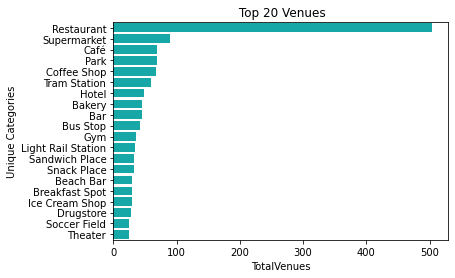

In [18]:
sns.barplot(data=df_venue_data.head(20), x='TotalVenues', y = 'Unique Categories', color='c').set_title(" Top 20 Venues")

###  Most omnipresent venue category

Here we try to see how each venue category is spread in each neighborhood (district) of Hague. For example, as we can see from the graph below, restaurants and supermarkets are available in almost 40 of the 46 neighborhoods. Or we can say, that people have access to supermarkets within a Kilometer of their residence. 

In [19]:
df_venue_in_districts = dh_venues.groupby(by="VenueCategory", as_index=False)["District"].nunique()

In [20]:
df_venue_in_districts.rename(columns = {"District":"DistinctDistricts"}, inplace=True)

In [21]:
df_venue_in_districts.sort_values(['DistinctDistricts'], ascending=False, inplace = True)

Text(0.5, 0, 'Available in Districts')

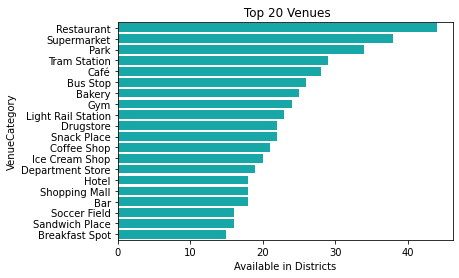

In [22]:
sns.barplot(data=df_venue_in_districts.head(20), x='DistinctDistricts', y = 'VenueCategory', color='c').set_title(" Top 20 Venues")
plt.xlabel("Available in Districts")

### Top Neighborhoods (districts) with most venues

From this data we can also extract which neighborhood has most venues in them or within 1 Km. We see from the graph below that the top 5 neighborhoods (districts) have 100 venues. We must be aware that we had set our limit to 100 in our query, so these 5 districts have reached their maximum query limit. 

We have mapped these 5 districts and we notice that they are right in the center of the city and 1 of them on the beach which is a very popular beach in entire Netherlands. So the results appear to show reality.

In [23]:
df_citybased= dh_venues.groupby(by=['District'], as_index=False).count()
df_district_data = df_citybased.loc[:,['District','Venue']]

In [24]:
df_district_data.rename(columns ={"Venue":"TotalVenues"},  inplace = True)

In [25]:

df_district_data.sort_values(['TotalVenues'], ascending = False, inplace = True)

Text(0.5, 1.0, ' Top 20 Districts')

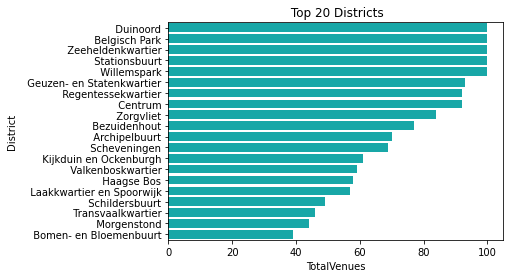

In [26]:
sns.barplot(data=df_district_data.head(20), x='TotalVenues', y = 'District', color='c').set_title(" Top 20 Districts")

In [27]:
districts_limited = df_district_data.head()['District']
d=districts_limited.tolist()

limited_districts_to_map = city_dh[city_dh['district'].isin(d)]


In [28]:
map_districts = folium.Map(location=(city_dh.iloc[29,3],city_dh.iloc[29,2]), zoom_start=12)
#map_hague = folium.Map()

for lat, lon, city in zip(city_dh['LAT'], city_dh['LONG'],
                          city_dh['district']):
    label = '{}, NL'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                    radius=5,
                    popup=label,
                    color='blue',
                    fill=True,
                    fill_color='blue',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_districts)
    
for lat, lon, city in zip(limited_districts_to_map['LAT'], limited_districts_to_map['LONG'],
                          limited_districts_to_map['district']):
    label = '{}, NL'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                    radius=5,
                    popup=label,
                    color='red',
                    fill=True,
                    fill_color='red',
                    fill_opacity=1.0,
                    parse_html=False).add_to(map_districts)


map_districts

## Step 6: Preparation for Cluster Analysis

### Preparing for one-hot encoding

In order to prepare for the cluster analysis, we have to encode each category into a binary value combination such that each combination falls into one category. This would also require us to regroup the data based on neighborhood (district). We do this in the next two steps.

In [29]:
# one hot encoding
dh_onehot = pd.get_dummies(dh_venues[['VenueCategory']], prefix="", prefix_sep="")


dh_onehot['District'] = dh_venues['District'] 


fixed_columns = [dh_onehot.columns[-1]] + list(dh_onehot.columns[:-1])
dh_onehot = dh_onehot[fixed_columns]

#dh_onehot.head()

In [30]:
dh_grouped = dh_onehot.groupby('District').mean().reset_index()
dh_grouped.head()

,District,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,...,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Vacation Rental,Video Game Store,Wine Bar,Yoga Studio
0,Archipelbuurt,0.00,0.014286,0.014286,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.000000,0.014286,0.014286,0.0,0.0,0.028571,0.0
1,Belgisch Park,0.01,0.000000,0.000000,0.0,0.0,0.00,0.0,0.01,0.0,...,0.0,0.000000,0.0,0.000000,0.020000,0.000000,0.0,0.0,0.000000,0.0
2,Benoordenhout,0.00,0.000000,0.000000,0.0,0.0,0.04,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,Bezuidenhout,0.00,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.012987,0.0,0.025974,0.038961,0.000000,0.0,0.0,0.000000,0.0
4,Binckhorst,0.00,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.000000,0.0,0.000000,0.037037,0.000000,0.0,0.0,0.000000,0.0


### The most common categories for each neighborhood

In [31]:
def get_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


number_of_top_categories = 7
indicators = ['st', 'nd', 'rd']

In [32]:
# create columns according to number of top venues
columns = ['District']
for ind in np.arange(number_of_top_categories):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
dh_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
dh_neighborhoods_categories_sorted['District'] = dh_grouped['District']

for ind in np.arange(dh_grouped.shape[0]):
    dh_neighborhoods_categories_sorted.iloc[ind, 1:] = get_most_common_venues(
        dh_grouped.iloc[ind, :], number_of_top_categories)

dh_neighborhoods_categories_sorted.head()

,District,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,Archipelbuurt,Restaurant,Bar,Café,Hotel,Park,Wine Bar,Sandwich Place
1,Belgisch Park,Restaurant,Beach Bar,Lounge,Hotel,Ice Cream Shop,Beach,Creperie
2,Benoordenhout,Restaurant,Café,Bus Stop,Soccer Field,Tea Room,Playground,Plaza
3,Bezuidenhout,Restaurant,Bakery,Supermarket,Tram Station,Café,Snack Place,Sandwich Place
4,Binckhorst,Restaurant,Supermarket,Coffee Shop,Discount Store,Rental Car Location,Bus Stop,Nightclub


## 7. Cluster Analysis


### How many clusters are good?

C:\Users\srirama\anaconda3\envs\coursera\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


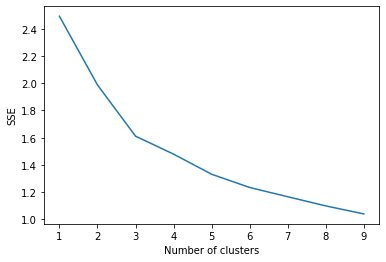

In [33]:
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(dh_grouped.drop('District',axis=1))
    dh_grouped['ClusterN'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Using 5 Clusters

We analysed our data with a range of 1 to 10 clusters and the elbow chart above shows that around 5 clusters are a good fit for our data. In the following steps, we will analyse our data with 5 clusters

In [34]:
kclusters = 5

dh_grouped_clustering = dh_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 4, 3, 4, 3, 4, 1])

In [35]:
# add clustering labels
dh_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



# merge original districts data to add latitude/longitude for each neighborhood
dh_merged = city_dh.join(dh_neighborhoods_categories_sorted.set_index('District'), on='district')

dh_merged.drop(['WK_NAAM','GM_NAAM'],axis=1).head() # check the last columns!

,LONG,LAT,district,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,4.307444,52.117355,Oostduinen,3,Café,Monument / Landmark,Nudist Beach,Outdoor Supply Store,Museum,Music Venue,Nature Preserve
1,4.292225,52.113130,Belgisch Park,0,Restaurant,Beach Bar,Lounge,Hotel,Ice Cream Shop,Beach,Creperie
2,4.303487,52.105014,Westbroekpark en Duttendel,4,Restaurant,Pharmacy,Tennis Court,Theme Park,Park,Circus,Café
3,4.321618,52.098392,Benoordenhout,4,Restaurant,Café,Bus Stop,Soccer Field,Tea Room,Playground,Plaza
4,4.302983,52.092814,Archipelbuurt,0,Restaurant,Bar,Café,Hotel,Park,Wine Bar,Sandwich Place


In [36]:
dh_merged.shape

(46, 13)

## Mapping the clusters

In [37]:


custom_colors5 = ["dodgerblue", "lightskyblue", "gold", "orangered", "brown"]

In [38]:
# create map
map_clusters = folium.Map(location=(city_dh.iloc[29,3],city_dh.iloc[29,2]), zoom_start=12)

# set color scheme for the clusters
rainbow = pc[:5]


# add markers to the map
for lat, lon, poi, cluster in zip(dh_merged['LAT'], dh_merged['LONG'], 
                                  dh_merged['district'], dh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=custom_colors5[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

### Check the clusters

The table below shows how many districts are included in each cluster. 

In [43]:
df_cluster_data= dh_merged['Cluster Labels'].value_counts().rename_axis('Cluster').reset_index(name='Districts')
df_cluster_data.head()

,Cluster,Districts
0,0,18
1,4,14
2,3,6
3,1,5
4,2,3


### Prominent venues 

The table below shows the 5 most prominent venues in each cluster.

In [150]:
district_cluster_map = {}

for d, c in zip(dh_merged['district'], dh_merged['Cluster Labels']):
    district_cluster_map[d] = c
    


dh_venues_cluster = dh_venues.copy()
dh_venues_cluster['Cluster'] = dh_venues_cluster['District'].map(district_cluster_map)
#dh_venues_cluster.head()

temp_grouping=dh_venues_cluster[['Cluster','VenueCategory']].groupby(['Cluster', 'VenueCategory'])['VenueCategory'].count().rename("Total Venues").reset_index()
top5_eachCluster =temp_grouping.sort_values(['Cluster','Total Venues'], ascending=False).groupby(['Cluster']).head(5).reset_index(drop=True)
top5_eachCluster

,Cluster,VenueCategory,Total Venues
0,4,Restaurant,80
1,4,Supermarket,20
2,4,Park,19
3,4,Gym,18
4,4,Bus Stop,16
5,3,Supermarket,14
6,3,Light Rail Station,11
7,3,Restaurant,11
8,3,Park,10
9,3,Tram Station,9


## 8. Conclusions

- The clusters represent reality. The city has a circular development. The inner most circle is the oldest and the outer most is the latest development.
- As we go to the outer clusters, we see more transportation venues, these transportation modes are used to bring people into the city center
- Cluster vs Time of Development:
    - Cluster0 is the oldest part of the city
    - Cluster4 is the second oldest part of the city
    - Cluster3 is the outer part of the city
    - Cluster1 are new developments evident with presence shopping malls
    - Cluster2 are almost suburban in nature and is evident by the presence of Trams and Metro stations as the prominent venues.
  